In [1]:
# imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pydataset import data

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, RFE, f_regression

___
# [Select K Best](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest)

- looks at each feature in isolation against the target based on correlation
- fastest of all approaches covered in this lesson
- doesn't consider feature interactions
- After fitting: `.scores_`, `.pvalues_`, `.get_support()`, and `.transform`

___
# [RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE)

- Recursive Feature Elimination
- Progressively eliminate features based on importance to the model
- Requires a model with either a `.coef_` or `.feature_importances_` property
- After fitting: `.ranking_`, `.get_support()`, and `.transform()`

___
# [Sequential Feature Selector](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector)

- Progressively adds features based on cross validated model performance
- Direction:
    - **`Forward`**: (*default*) start with 0, add the best additional feature until you have the desired number
    - **`Backward`**: start with all features, remove the worst performing until you have the desired number
- After fitting: `.support_`, `.transform`

# Exercises

#### 1. Load the `tips` dataset.


In [2]:
df = data('tips')
df

,total_bill,tip,sex,smoker,day,time,size
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
240,29.03,5.92,Male,No,Sat,Dinner,3
241,27.18,2.00,Female,Yes,Sat,Dinner,2
242,22.67,2.00,Male,Yes,Sat,Dinner,2
243,17.82,1.75,Male,No,Sat,Dinner,2


- Create a column named `price_per_person`. This should be the total bill divided by the party size.


In [3]:
df = df.assign(ppp=(df.total_bill/df['size']))
df

,total_bill,tip,sex,smoker,day,time,size,ppp
1,16.99,1.01,Female,No,Sun,Dinner,2,8.495000
2,10.34,1.66,Male,No,Sun,Dinner,3,3.446667
3,21.01,3.50,Male,No,Sun,Dinner,3,7.003333
4,23.68,3.31,Male,No,Sun,Dinner,2,11.840000
5,24.59,3.61,Female,No,Sun,Dinner,4,6.147500
...,...,...,...,...,...,...,...,...
240,29.03,5.92,Male,No,Sat,Dinner,3,9.676667
241,27.18,2.00,Female,Yes,Sat,Dinner,2,13.590000
242,22.67,2.00,Male,Yes,Sat,Dinner,2,11.335000
243,17.82,1.75,Male,No,Sat,Dinner,2,8.910000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 1 to 244
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
 7   ppp         244 non-null    float64
dtypes: float64(3), int64(1), object(4)
memory usage: 17.2+ KB


In [5]:
df['female'] = df.sex.map({'Female': 1, 'Male': 0})
df['smokes'] = df.smoker.map({'Yes': 1, 'No': 0})
dummy_df = pd.get_dummies(df[['day','time']], dummy_na=False)
df = pd.concat([df, dummy_df], axis=1)
df = df.drop(columns=['time_Dinner'])

In [6]:
df.head()

,total_bill,tip,sex,smoker,day,time,size,ppp,female,smokes,day_Fri,day_Sat,day_Sun,day_Thur,time_Lunch
1,16.99,1.01,Female,No,Sun,Dinner,2,8.495000,1,0,0,0,1,0,0
2,10.34,1.66,Male,No,Sun,Dinner,3,3.446667,0,0,0,0,1,0,0
3,21.01,3.50,Male,No,Sun,Dinner,3,7.003333,0,0,0,0,1,0,0
4,23.68,3.31,Male,No,Sun,Dinner,2,11.840000,0,0,0,0,1,0,0
5,24.59,3.61,Female,No,Sun,Dinner,4,6.147500,1,0,0,0,1,0,0


In [7]:
from wrangle import split_data

In [8]:
train,val,test = split_data(df)
train.head()

,total_bill,tip,sex,smoker,day,time,size,ppp,female,smokes,day_Fri,day_Sat,day_Sun,day_Thur,time_Lunch
101,11.35,2.50,Female,Yes,Fri,Dinner,2,5.675000,1,1,1,0,0,0,0
183,45.35,3.50,Male,Yes,Sun,Dinner,3,15.116667,0,1,0,0,1,0,0
49,28.55,2.05,Male,No,Sun,Dinner,3,9.516667,0,0,0,0,1,0,0
119,12.43,1.80,Female,No,Thur,Lunch,2,6.215000,1,0,0,0,0,1,1
62,13.81,2.00,Male,Yes,Sat,Dinner,2,6.905000,0,1,0,1,0,0,0


In [9]:
import sklearn.preprocessing

In [10]:
mm_scale = sklearn.preprocessing.MinMaxScaler()
feature = ['total_bill','size','ppp','female','smokes','day_Sat','day_Sun','day_Thur','time_Lunch']
Xtr,Xv,Xt = train[feature],val[feature],test[feature]
ytr,yv,yt = train.tip,val.tip,test.tip
scale = feature
scaled = ['total_bill_s','size_s','ppp_s','female_s','smokes_s','day_Sat_s','day_Sun_s','day_Thur_s','time_Lunch_s']
Xtr_s = pd.DataFrame(mm_scale.fit_transform(Xtr[scale]),Xtr.index,scaled)
Xv_s = pd.DataFrame(mm_scale.fit_transform(Xv[scale]),Xv.index,scaled)
Xt_s = pd.DataFrame(mm_scale.fit_transform(Xt[scale]),Xt.index,scaled)

In [11]:
Xtr_s.head()

,total_bill_s,size_s,ppp_s,female_s,smokes_s,day_Sat_s,day_Sun_s,day_Thur_s,time_Lunch_s
101,0.094123,0.2,0.149744,1.0,1.0,0.0,0.0,0.0,0.0
183,0.874656,0.4,0.839421,0.0,1.0,0.0,1.0,0.0,0.0
49,0.488981,0.4,0.430363,0.0,0.0,0.0,1.0,0.0,0.0
119,0.118916,0.2,0.189189,1.0,0.0,0.0,0.0,1.0,1.0
62,0.150597,0.2,0.239591,0.0,1.0,1.0,0.0,0.0,0.0


- Before using any of the methods discussed in the lesson, which features do you think would be most important for predicting the tip amount?


In [12]:
# total_bill for sure, maybe size and price per person

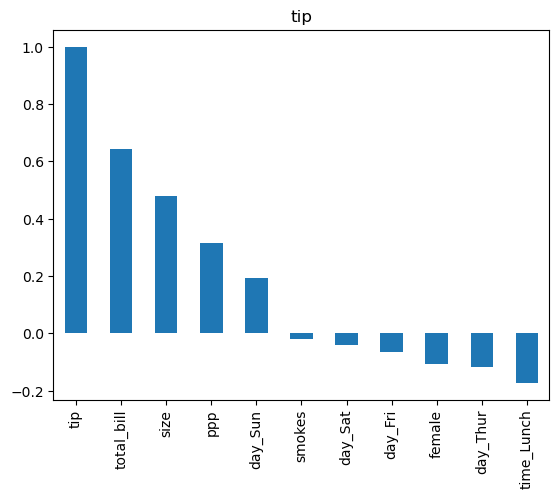

In [13]:
train.corr()['tip'].sort_values(ascending = False).plot(kind='bar')
plt.title('tip')
plt.show()

- Use select k best to select the top 2 features for predicting tip amount. What are they?


In [14]:
f_sel = SelectKBest(f_regression,k=2)
f_sel.fit(Xtr_s,ytr)
f_mask = f_sel.get_support()
ff = Xtr_s.iloc[:,f_mask].columns.to_list()

In [15]:
ff

['total_bill_s', 'size_s']

In [16]:
f_sel_results = pd.DataFrame(dict(p_value=f_sel.pvalues_, f_score=f_sel.scores_),index=Xtr_s.columns)
f_sel_results.sort_values('f_score',ascending=False)

,p_value,f_score
total_bill_s,2.678071e-18,100.725447
size_s,1.090655e-09,42.553258
ppp_s,1.069043e-04,15.878404
day_Sun_s,2.014211e-02,5.521484
time_Lunch_s,3.778018e-02,4.395615
day_Thur_s,1.545511e-01,2.048218
female_s,2.012406e-01,1.648387
day_Sat_s,6.293269e-01,0.233975
smokes_s,8.283551e-01,0.047179


- Use recursive feature elimination to select the top 2 features for tip amount. What are they?


In [17]:
lr = LinearRegression()
rfe = RFE(lr,n_features_to_select=2)
rfe.fit(Xtr_s,ytr)
f_mask = rfe.support_
rfe_f = Xtr_s.iloc[:,f_mask].columns.to_list()

In [18]:
rfe_f

['total_bill_s', 'ppp_s']

In [19]:
var_ranks = rfe.ranking_
var_names = Xtr_s.columns.to_list()
rfe_ranks_df = pd.DataFrame({'Var':var_names,'Rank':var_ranks})
rfe_ranks_df.sort_values('Rank')

,Var,Rank
0,total_bill_s,1
2,ppp_s,1
1,size_s,2
5,day_Sat_s,3
8,time_Lunch_s,4
7,day_Thur_s,5
3,female_s,6
4,smokes_s,7
6,day_Sun_s,8


- Why do you think select k best and recursive feature elimination might give different answers for the top features? Does this change as you change the number of features you are selecting?

In [20]:
# SelectKBest uses stat testing
# RFE builds models and picks which features gave best metrics
# scaling method does influence

#### 2. Write a function named `select_kbest` that takes in the predictors (X), the target (y), and the number of features to select (k) and returns the names of the top k selected features based on the `SelectKBest` class. Test your function with the `tips` dataset. You should see the same results as when you did the process manually.

In [21]:
def select_kbest(X,y,k):
    f_sel = SelectKBest(f_regression,k=k)
    f_sel.fit(X,y)
    f_mask = f_sel.get_support()
    return X.iloc[:,f_mask].columns.to_list()

In [22]:
select_kbest(Xtr_s,ytr,2)

['total_bill_s', 'size_s']

#### 3. Write a function named `rfe` that takes in the predictors, the target, and the number of features to select. It should return the top k features based on the `RFE` class. Test your function with the `tips` dataset. You should see the same results as when you did the process manually.

In [23]:
def rfe(X,y,f):
    lr = LinearRegression()
    rfe = RFE(lr,n_features_to_select=f)
    rfe.fit(X,y)
    f_mask = rfe.support_
    return X.iloc[:,f_mask].columns.to_list()

In [24]:
rfe(Xtr_s,ytr,2)

['total_bill_s', 'ppp_s']

#### 4. Load the `swiss` dataset and use all the other features to predict Fertility. Find the top 3 features using both select k best and recursive feature elimination (use the functions you just built to help you out).

In [25]:
df = data('swiss')
df.head()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, Courtelary to Rive Gauche
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fertility         47 non-null     float64
 1   Agriculture       47 non-null     float64
 2   Examination       47 non-null     int64  
 3   Education         47 non-null     int64  
 4   Catholic          47 non-null     float64
 5   Infant.Mortality  47 non-null     float64
dtypes: float64(4), int64(2)
memory usage: 2.6+ KB


In [27]:
train,val,test = split_data(df)
train.head()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Echallens,68.3,72.6,18,2,24.20,21.2
Entremont,69.3,84.9,7,6,99.68,19.8
Herens,77.3,89.7,5,2,100.00,18.3
Glane,92.4,67.8,14,8,97.16,24.9
Sarine,82.9,45.2,16,13,91.38,24.4


In [28]:
mm_scale = sklearn.preprocessing.MinMaxScaler()
feature = ['Agriculture','Examination','Education','Catholic','Infant.Mortality']
Xtr,Xv,Xt = train[feature],val[feature],test[feature]
ytr,yv,yt = train.Fertility,val.Fertility,test.Fertility
scaled = ['Agriculture_s','Examination_s','Education_s','Catholic_s','Infant.Mortality_s']
Xtr_s = pd.DataFrame(mm_scale.fit_transform(Xtr[feature]),Xtr.index,scaled)
Xv_s = pd.DataFrame(mm_scale.fit_transform(Xv[feature]),Xv.index,scaled)
Xt_s = pd.DataFrame(mm_scale.fit_transform(Xt[feature]),Xt.index,scaled)

In [29]:
Xtr_s.head()

,Agriculture_s,Examination_s,Education_s,Catholic_s,Infant.Mortality_s
Echallens,0.806780,0.40625,0.000000,0.220004,0.559524
Entremont,0.945763,0.06250,0.078431,0.996707,0.392857
Herens,1.000000,0.00000,0.000000,1.000000,0.214286
Glane,0.752542,0.28125,0.117647,0.970776,1.000000
Sarine,0.497175,0.34375,0.215686,0.911299,0.940476


In [30]:
select_kbest(Xtr_s,ytr,3)

['Examination_s', 'Education_s', 'Infant.Mortality_s']

In [31]:
rfe(Xtr_s,ytr,3)

['Agriculture_s', 'Education_s', 'Catholic_s']

## Try with zillow

In [32]:
import wrangle as w
import prepare as p

In [33]:
df = w.wrangle_zillow()
df.head()

,year,beds,baths,area,prop_value,prop_tax,county
0,2005,4,2.0,3633,296425,6941.39,LA
1,2011,3,4.0,1620,847770,10244.94,LA
2,1926,3,2.0,2077,646760,7924.68,LA
6,1950,3,1.0,1244,169471,2532.88,LA
7,1950,3,2.0,1300,233266,3110.99,LA


In [34]:
df = df.assign(rooms=(df.beds+df.baths))
df = df.assign(decade=pd.cut(x=df.year,bins=22,labels=[1800,1810,1820,1830,1840,1850,1860,1870,1880,1890,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010]))
df = df.assign(ppa=(df.prop_tax/df.area))
df = df.assign(age=(2017-df.year))
df = df.assign(space=(df.beds*200+df.baths*40))
df = df.assign(half_bath=np.where(df.baths==df.baths.astype(int),0,1))
df

,year,beds,baths,area,prop_value,prop_tax,county,rooms,decade,ppa,age,space,half_bath
0,2005,4,2.0,3633,296425,6941.39,LA,6.0,2000,1.910650,12,880.0,0
1,2011,3,4.0,1620,847770,10244.94,LA,7.0,2010,6.324037,6,760.0,0
2,1926,3,2.0,2077,646760,7924.68,LA,5.0,1920,3.815445,91,680.0,0
6,1950,3,1.0,1244,169471,2532.88,LA,4.0,1950,2.036077,67,640.0,0
7,1950,3,2.0,1300,233266,3110.99,LA,5.0,1950,2.393069,67,680.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2140230,2015,4,4.0,4375,422400,13877.56,LA,8.0,2010,3.172014,2,960.0,0
2140231,2015,4,3.0,2262,960756,13494.52,Orange,7.0,2010,5.965747,2,920.0,0
2140232,2014,4,4.5,3127,536061,6244.16,Orange,8.5,2010,1.996853,3,980.0,1
2140233,2015,3,2.5,1974,424353,5302.70,Orange,5.5,2010,2.686272,2,700.0,1


In [35]:
df = p.encode_county(df)
df

,year,beds,baths,area,prop_value,prop_tax,county,rooms,decade,ppa,age,space,half_bath,Orange,Ventura
0,2005,4,2.0,3633,296425,6941.39,LA,6.0,2000,1.910650,12,880.0,0,0,0
1,2011,3,4.0,1620,847770,10244.94,LA,7.0,2010,6.324037,6,760.0,0,0,0
2,1926,3,2.0,2077,646760,7924.68,LA,5.0,1920,3.815445,91,680.0,0,0,0
6,1950,3,1.0,1244,169471,2532.88,LA,4.0,1950,2.036077,67,640.0,0,0,0
7,1950,3,2.0,1300,233266,3110.99,LA,5.0,1950,2.393069,67,680.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2140230,2015,4,4.0,4375,422400,13877.56,LA,8.0,2010,3.172014,2,960.0,0,0,0
2140231,2015,4,3.0,2262,960756,13494.52,Orange,7.0,2010,5.965747,2,920.0,0,1,0
2140232,2014,4,4.5,3127,536061,6244.16,Orange,8.5,2010,1.996853,3,980.0,1,1,0
2140233,2015,3,2.5,1974,424353,5302.70,Orange,5.5,2010,2.686272,2,700.0,1,1,0


In [36]:
train,val,test = w.split_data(df)
train

,year,beds,baths,area,prop_value,prop_tax,county,rooms,decade,ppa,age,space,half_bath,Orange,Ventura
558946,1953,2,1.0,989,141500,2446.95,LA,3.0,1950,2.474166,64,440.0,0,0,0
156655,1972,4,2.0,2054,555982,6570.12,LA,6.0,1970,3.198695,45,880.0,0,0,0
2055932,1945,2,1.0,774,237093,2945.65,LA,3.0,1940,3.805749,72,440.0,0,0,0
687070,1958,3,2.0,1570,431696,5390.83,LA,5.0,1960,3.433650,59,680.0,0,0,0
1496477,2007,4,3.0,1919,598904,6709.22,Orange,7.0,2010,3.496206,10,920.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723557,1955,5,2.0,1811,490263,1244.70,LA,7.0,1950,0.687300,62,1080.0,0,0,0
587409,1971,3,2.0,1273,676152,6965.32,Orange,5.0,1970,5.471579,46,680.0,0,1,0
1801850,1939,2,1.0,1153,173237,2260.89,LA,3.0,1940,1.960876,78,440.0,0,0,0
352380,1947,3,1.0,1138,220705,3130.73,LA,4.0,1940,2.751081,70,640.0,0,0,0


In [37]:
scale = train.drop(columns=['prop_value','county','half_bath','Orange','Ventura']).columns.to_list()

In [38]:
trm,vm,tm=p.mm_zillow(train,val,test,scale)
trs,vs,ts=p.std_zillow(train,val,test,scale)
trr,vr,tr=p.robs_zillow(train,val,test,scale)
trn,vn,tn=p.qtf_zillow(train,val,test,'normal',scale)
tru,vu,tu=p.qtf_zillow(train,val,test,'uniform',scale)

In [39]:
for col in scale:
    trm = trm.rename(columns={col: f'{col}_s'})
    trs = trs.rename(columns={col: f'{col}_s'})
    trr = trr.rename(columns={col: f'{col}_s'})
    trn = trn.rename(columns={col: f'{col}_s'})
    tru = tru.rename(columns={col: f'{col}_s'})
Xtr_m = trm.drop(columns=['prop_value','county'])
Xtr_s = trs.drop(columns=['prop_value','county'])
Xtr_r = trr.drop(columns=['prop_value','county'])
Xtr_n = trn.drop(columns=['prop_value','county'])
Xtr_u = tru.drop(columns=['prop_value','county'])

In [40]:
ytr = train.prop_value
ytr

558946     141500
156655     555982
2055932    237093
687070     431696
1496477    598904
            ...  
723557     490263
587409     676152
1801850    173237
352380     220705
394176     524127
Name: prop_value, Length: 1216851, dtype: int64

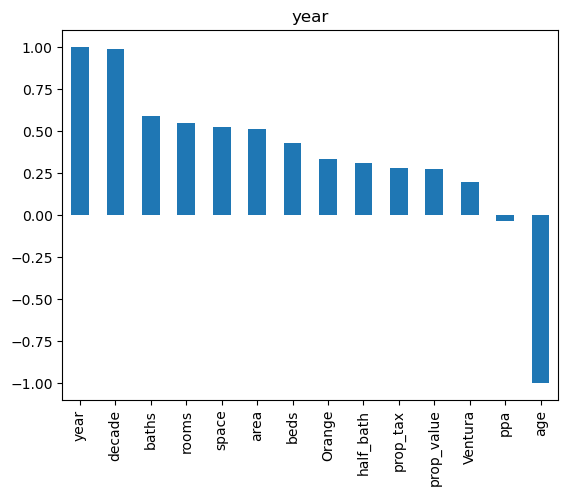

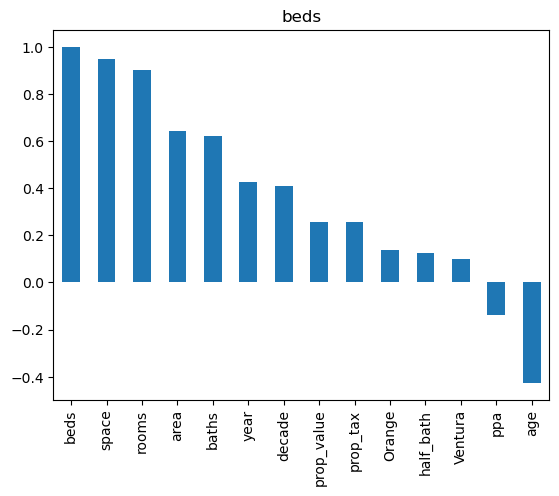

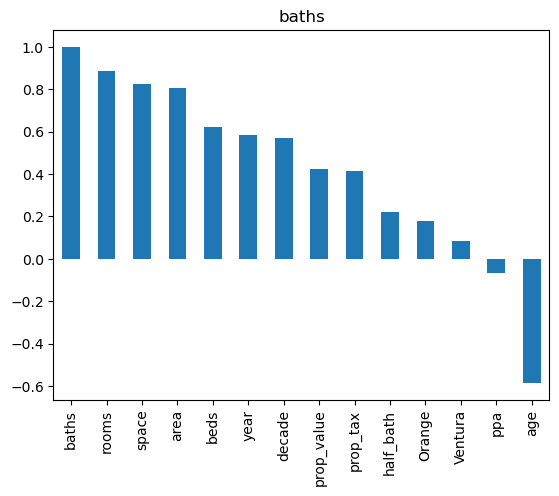

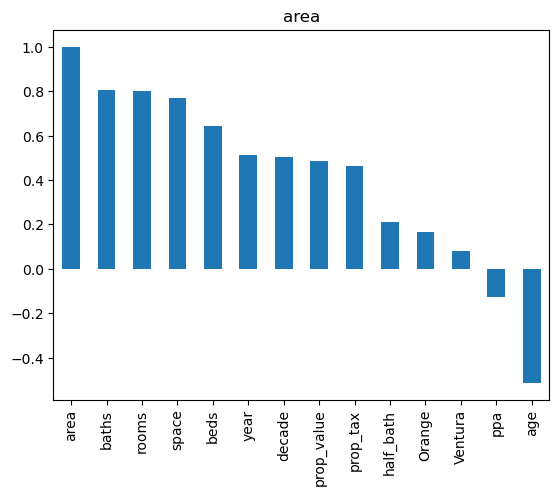

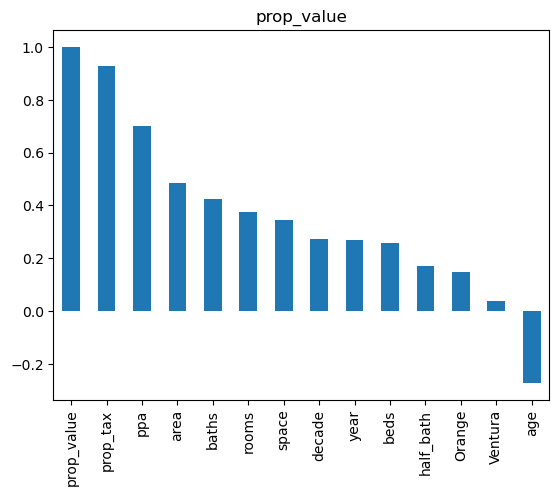

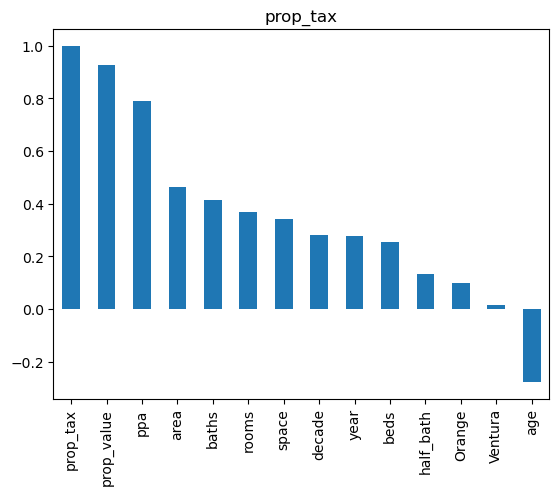

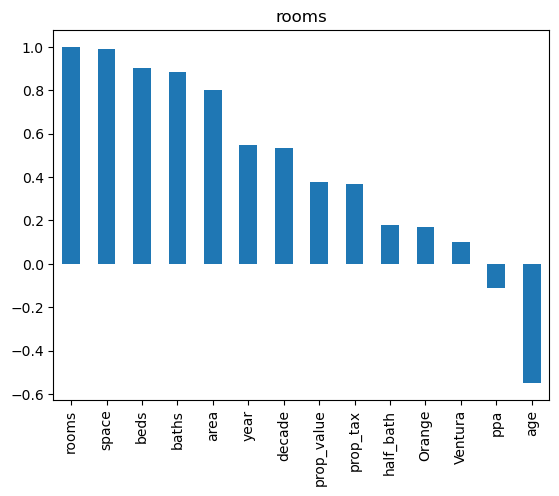

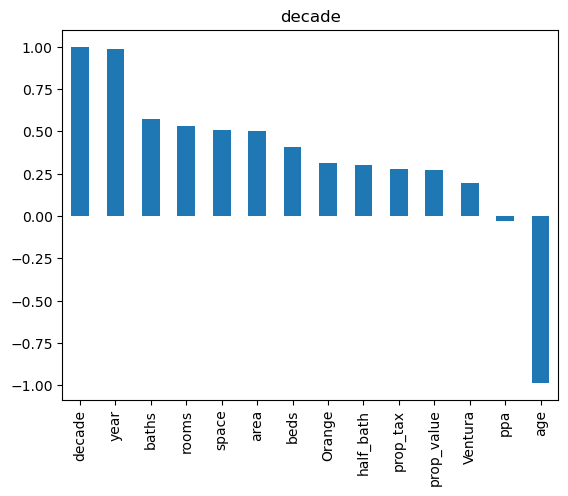

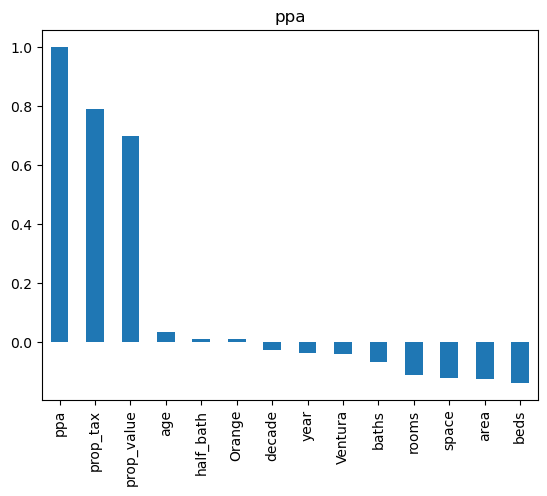

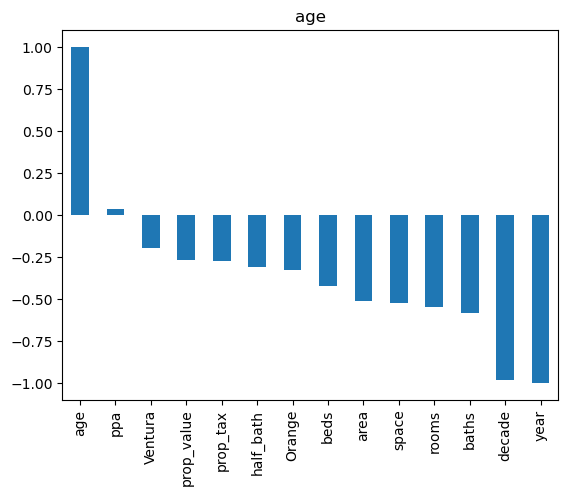

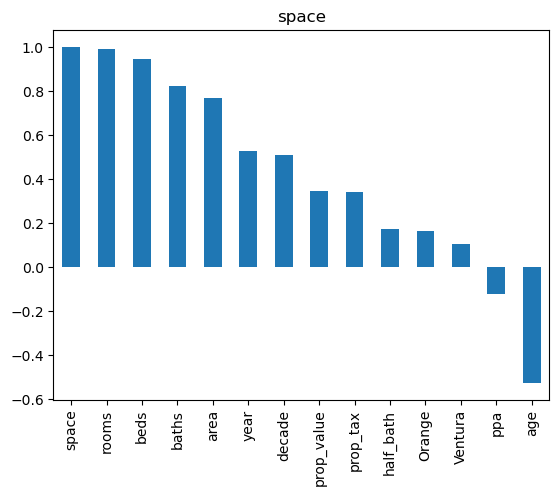

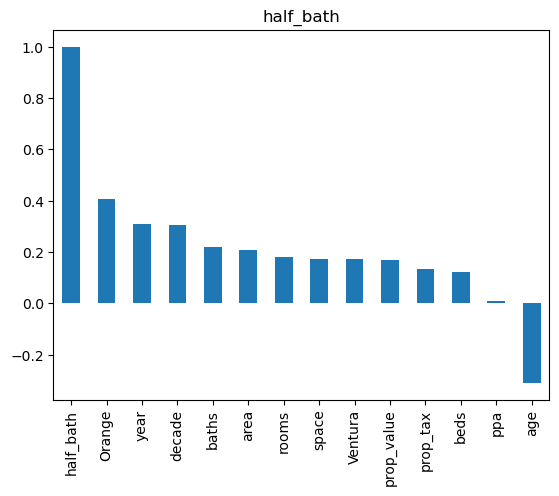

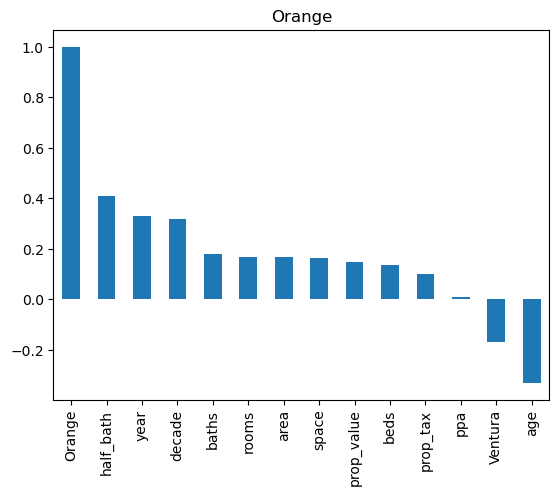

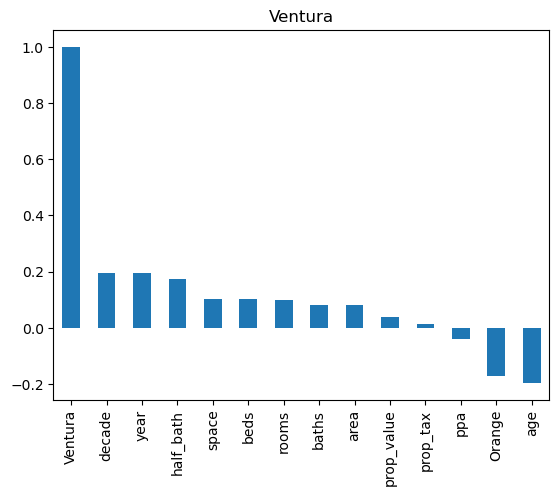

In [41]:
cols = train.drop(columns=['county']).columns
for col in cols:
    train.corr()[col].sort_values(ascending = False).plot(kind='bar')
    plt.title(col)
    plt.show()

In [42]:
# prop_tax_s, ppa_s, area_s, baths_s, rooms_s, space_s, decade_s, year_s, age_s, beds_s, half_bath, Orange, Ventura
select_kbest(Xtr_m,ytr,3)

['area_s', 'prop_tax_s', 'ppa_s']

In [43]:
def rfe_rev(X,y,f,show_df=False):
    lr = LinearRegression()
    rfe = RFE(lr,n_features_to_select=f)
    rfe.fit(X,y)
    if show_df==True:
        var_ranks = rfe.ranking_
        var_names = X.columns.to_list()
        rfe_ranks_df = pd.DataFrame({'Var':var_names,'Rank':var_ranks})
        return rfe_ranks_df.sort_values('Rank')
    else:
        f_mask = rfe.support_
        return X.iloc[:,f_mask].columns.to_list()


In [45]:
import itertools
fet = ['prop_tax_s', 'ppa_s', 'area_s', 'baths_s', 'rooms_s', 'space_s', 'decade_s', 'age_s', 'year_s', 'beds_s', 'half_bath', 'Orange', 'Ventura']
df1 = None
for x,r in itertools.product([Xtr_m[fet],Xtr_s[fet],Xtr_r[fet],Xtr_n[fet],Xtr_u[fet]],range(1,13)):
    df = rfe_rev(x,ytr,r,True)
    df = df.assign(n_features=r)
    df1 = pd.concat([df1,df]) if df1 is not None else df


In [46]:
df1

,Var,Rank,n_features
7,age_s,1,1
8,year_s,2,1
0,prop_tax_s,3,1
4,rooms_s,4,1
5,space_s,5,1
...,...,...,...
8,year_s,1,12
10,half_bath,1,12
11,Orange,1,12
12,Ventura,1,12


In [47]:
df1.groupby(['Var']).Rank.mean().sort_values()

Var
age_s         1.000000
year_s        1.083333
prop_tax_s    1.250000
rooms_s       1.500000
space_s       1.833333
area_s        2.250000
Orange        2.750000
Ventura       3.333333
ppa_s         4.000000
baths_s       4.750000
half_bath     5.583333
decade_s      6.500000
beds_s        7.500000
Name: Rank, dtype: float64